# Data Cleaning

## 1. Importing Packages and Loading Data

In [202]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns

In [204]:
df = pd.read_csv("/Users/matteo/Documents/PersonalProjects/airbnb-pricing-optimization/data/listings-2.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20250901181253,2025-09-01,city scrape,"Bright, Modern Garden Unit - 1BR/1BTH",Our bright garden unit overlooks a lovely back...,Quiet cul de sac in friendly neighborhood<br /...,https://a0.muscache.com/pictures/be1bf5ac-a955...,1169,...,4.89,4.98,4.78,STR-0006854,f,1,1,0,0,2.53
1,5858,https://www.airbnb.com/rooms/5858,20250901181253,2025-09-01,city scrape,Creative Sanctuary,We live in a large Victorian house on a quiet ...,I love how our neighborhood feels quiet but is...,https://a0.muscache.com/pictures/hosting/Hosti...,8904,...,4.85,4.77,4.68,NaN,f,1,1,0,0,0.53
2,8014,https://www.airbnb.com/rooms/8014,20250901181253,2025-09-01,city scrape,female HOST quiet fast internet market parking,Room is on the second floor so it gets a good ...,"The neighborhood is very residential, close to...",https://a0.muscache.com/pictures/2cc1fc3d-0ae0...,22402,...,4.94,4.59,4.66,STR-0000974,f,3,0,3,0,0.57
3,8142,https://www.airbnb.com/rooms/8142,20250901181253,2025-09-01,city scrape,*FriendlyRoom Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,"N Juda Muni, Bus and UCSF Shuttle.<br /><br />...",https://a0.muscache.com/pictures/hosting/Hosti...,21994,...,4.80,4.70,4.70,NaN,f,20,0,20,0,0.07
4,8339,https://www.airbnb.com/rooms/8339,20250901181253,2025-09-01,city scrape,Historic Alamo Square Victorian,"For creative humans who love art, space, photo...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,24215,...,5.00,4.94,4.75,STR-0000264,f,1,1,0,0,0.13


In [206]:
# check for NAs
df.isna().sum().sort_values(ascending = False)

neighbourhood_group_cleansed    7780
calendar_updated                7780
neighborhood_overview           3097
neighbourhood                   3097
host_about                      3084
                                ... 
minimum_nights_avg_ntm             0
maximum_nights_avg_ntm             0
availability_30                    0
availability_60                    0
amenities                          0
Length: 79, dtype: int64

## 2. Cleaning Data

In [209]:
# create new dataframe that will serve as the clean version of the raw dataframe
df_clean = df

### Pricing

In [212]:
# convert price to a float
df_clean["price"] = df_clean["price"].str.replace("$", "").str.replace(",", "").astype(float)


# save the observations with missing prices, and remove them from clean dataframe
df_missing_prices = df_clean[df_clean["price"].isna()]
df_clean = df_clean[df_clean["price"].isna() == False]


# log transform prices
df_clean["log_price"] = np.log(df_clean["price"])

/var/folders/l3/nx1r6y2154j6kp9618n899p80000gn/T/ipykernel_88494/2600617343.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Drop Unnecessary Columns

In [215]:
# drop neighbourhood_group_cleansed and calendar_updated --> all entries have NA's
# drop neighbourhood --> cleansed neighborhood variable available with no NA's
# drop neighborhood_overview --> large text variables with little effect on pricing
# drop host_about, host_location and host_neighbourhood --> many missing values, info about the host that is not relavent
# drop first_review and last_review --> many NA values, have multiple other review variables that will be more signficant
# drop max_max nights, min_max nights, etc. cols --> confusing and not helpful for predicting price
df_clean = df_clean.drop(columns = ["neighbourhood_group_cleansed", "calendar_updated", 
                                    "neighbourhood", 
                                    "neighborhood_overview", "host_about", 
                                    "host_location", "host_neighbourhood",
                                    "first_review", "last_review",
                                   "maximum_maximum_nights", "minimum_minimum_nights", 
                                    "maximum_minimum_nights", "minimum_maximum_nights"])

### Fill in NA's

In [218]:
# reviews per month NA's changed to 0's
df_clean["reviews_per_month"] = df_clean["reviews_per_month"].fillna(df_clean["reviews_per_month"].median())

# change all NA's in license to "None" because NA means that no license is present
df_clean["license"] = df_clean["license"].fillna("None")

# remove the single listing with no host name
df_clean = df_clean[df_clean["host_name"].isna() == False]

# make "host_response_rate" into a numeric variable by removing the percentages and making NA's median values
df_clean["host_response_rate"] = df_clean["host_response_rate"].str.replace("%", "").astype(float)
df_clean["host_response_rate"] = df_clean["host_response_rate"].fillna(df_clean["host_response_rate"].median())

# same thing for "host_acceptance_rate"
df_clean["host_acceptance_rate"] = df_clean["host_acceptance_rate"].str.replace("%", "").astype(float)
df_clean["host_acceptance_rate"] = df_clean["host_acceptance_rate"].fillna(df_clean["host_acceptance_rate"].median())

# fill NA's in "host_is_superhost" to f
df_clean["host_is_superhost"] = df_clean["host_is_superhost"].fillna("f")

# fill NA's in "has_availability" to f
df_clean["has_availability"] = df_clean["has_availability"].fillna("f")


# "host_response_time" --> convert to numeric
# "description" --> drop 66 rows? or fill with "no description"?
# "bedrooms" --> drop 32 rows?
# "beds" --> fill w median? or drop 26 rows?
# "bathrooms_text" --> new variable for shared/not shared bc bathroom var still present? only 14 NAs
# "bathrooms" --> drop 5 rows? 


### Impute Review Scores

In [221]:
# reviews NA changed to median of all reviews, these are scored 0-5 and if all NA's were changed to 0's, the data would be very skewed

df_clean["review_scores_location"] = df_clean["review_scores_location"].fillna(df_clean["review_scores_location"].median())
df_clean["review_scores_value"] = df_clean["review_scores_value"].fillna(df_clean["review_scores_value"].median())
df_clean["review_scores_rating"] = df_clean["review_scores_rating"].fillna(df_clean["review_scores_rating"].median())
df_clean["review_scores_cleanliness"] = df_clean["review_scores_cleanliness"].fillna(df_clean["review_scores_cleanliness"].median())
df_clean["review_scores_checkin"] = df_clean["review_scores_checkin"].fillna(df_clean["review_scores_checkin"].median())
df_clean["review_scores_communication"] = df_clean["review_scores_communication"].fillna(df_clean["review_scores_communication"].median())
df_clean["review_scores_accuracy"] = df_clean["review_scores_accuracy"].fillna(df_clean["review_scores_accuracy"].median())

### Miscellaneous

In [224]:
df_clean["bathrooms_text"]

0                 1 bath
1                2 baths
2         2 shared baths
3         4 shared baths
4              1.5 baths
              ...       
7775             2 baths
7776             2 baths
7777    1.5 shared baths
7778       1 shared bath
7779             3 baths
Name: bathrooms_text, Length: 5794, dtype: object

### Clean Dataframe Check

In [227]:
# check to make sure all NA's are handled
NAs = pd.DataFrame(df_clean.isna().sum().sort_values(ascending = False))
NAs[NAs[0] > 0]

,0
host_response_time,437
description,66
bedrooms,32
beds,26
bathrooms_text,14
bathrooms,5


In [28]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5794 entries, 0 to 7779
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5794 non-null   int64  
 1   listing_url                                   5794 non-null   object 
 2   scrape_id                                     5794 non-null   int64  
 3   last_scraped                                  5794 non-null   object 
 4   source                                        5794 non-null   object 
 5   name                                          5794 non-null   object 
 6   description                                   5728 non-null   object 
 7   picture_url                                   5794 non-null   object 
 8   host_id                                       5794 non-null   int64  
 9   host_url                                      5794 non-null   object

In [30]:
df_clean.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,log_price
0,958,https://www.airbnb.com/rooms/958,20250901181253,2025-09-01,city scrape,"Bright, Modern Garden Unit - 1BR/1BTH",Our bright garden unit overlooks a lovely back...,https://a0.muscache.com/pictures/be1bf5ac-a955...,1169,https://www.airbnb.com/users/show/1169,...,4.98,4.78,STR-0006854,f,1,1,0,0,2.53,5.056246
1,5858,https://www.airbnb.com/rooms/5858,20250901181253,2025-09-01,city scrape,Creative Sanctuary,We live in a large Victorian house on a quiet ...,https://a0.muscache.com/pictures/hosting/Hosti...,8904,https://www.airbnb.com/users/show/8904,...,4.77,4.68,None,f,1,1,0,0,0.53,5.521461
2,8014,https://www.airbnb.com/rooms/8014,20250901181253,2025-09-01,city scrape,female HOST quiet fast internet market parking,Room is on the second floor so it gets a good ...,https://a0.muscache.com/pictures/2cc1fc3d-0ae0...,22402,https://www.airbnb.com/users/show/22402,...,4.59,4.66,STR-0000974,f,3,0,3,0,0.57,4.204693
3,8142,https://www.airbnb.com/rooms/8142,20250901181253,2025-09-01,city scrape,*FriendlyRoom Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,https://a0.muscache.com/pictures/hosting/Hosti...,21994,https://www.airbnb.com/users/show/21994,...,4.70,4.70,None,f,20,0,20,0,0.07,4.025352
4,8339,https://www.airbnb.com/rooms/8339,20250901181253,2025-09-01,city scrape,Historic Alamo Square Victorian,"For creative humans who love art, space, photo...",https://a0.muscache.com/pictures/miso/Hosting-...,24215,https://www.airbnb.com/users/show/24215,...,4.94,4.75,STR-0000264,f,1,1,0,0,0.13,6.267201


/Users/matteo/opt/anaconda3/envs/airbnb/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 68'. Pick better value with 'binwidth'.


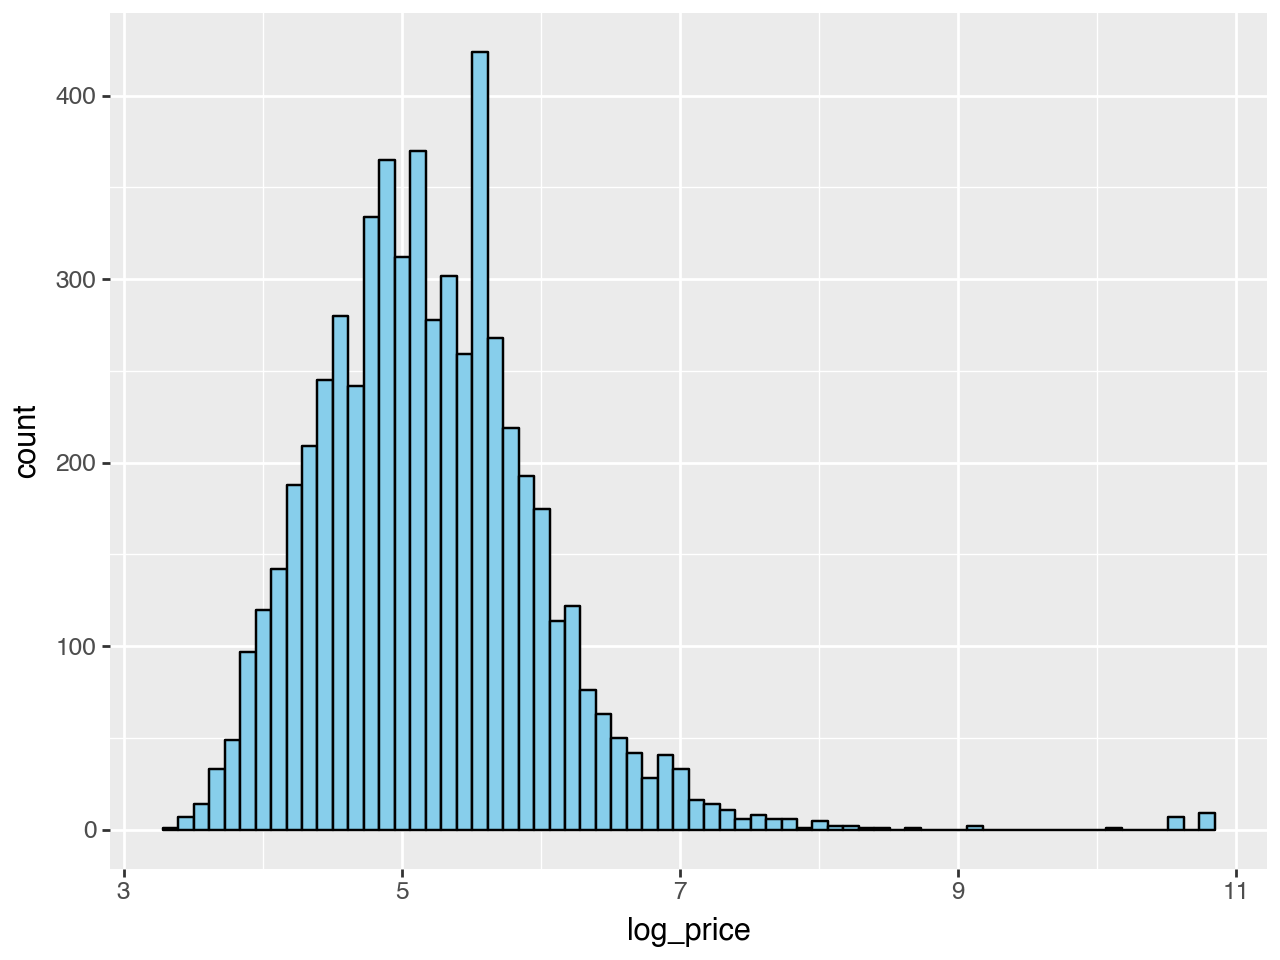

In [32]:
# testing log transform for price

(
    ggplot(df_clean, mapping = aes(x = "log_price")) +
           geom_histogram(fill = "skyblue", color = "black")
)

## 3. Initial Model Training

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [25]:
quantitative_vars = ["latitude", "longitude", "minimum_nights", "number_of_reviews", 
                      "calculated_host_listings_count", "availability_365", "number_of_reviews_ltm"]

categorical_vars = ["neighbourhood", "room_type"]

target = "log_price"

X = df_clean.drop(["id", "host_id", "price", "log_price", "name", "host_name", "last_review", "license"], axis = 1)
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# preprocessing

preproc = make_column_transformer(
    (StandardScaler(), quantitative_vars),
    (OneHotEncoder(), categorical_vars)
)

In [27]:
# define and fit model 

Linear_Pipeline = make_pipeline(
    preproc,
    LinearRegression()
)

Linear_Pipeline.fit(X_train, y_train)

ValueError: A given column is not a column of the dataframe

In [ ]:
y_pred = Linear_Pipeline.predict(X_test)

y_pred
np.ravel(y_test)

In [ ]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

In [ ]:
preproc = Linear_Pipeline.named_steps["columntransformer"]
lin     = Linear_Pipeline.named_steps["linearregression"]


feat_names = preproc.get_feature_names_out()
coefs = lin.coef_.ravel()
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})

In [ ]:
coef_df.sort_values("coef", ascending = False)